In [2]:
import random
import math
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [3]:
# Import necessary modules
import sys
import os

# Add the 'src' directory to the system path if it's not already
sys.path.append(os.path.abspath(os.path.join('environment')))
from environment import BlackjackGame

In [4]:
def test_td_model(agent, env, num_test_games=1000000, true_count=2):
    """
    Test the TemporalDifference agent in the given environment.

    Args:
        agent (TemporalDifference): The trained agent to test.
        env (BlackjackGame): The environment to test the agent on.
        num_test_games (int): Number of test games to evaluate.
        true_count (int): True count to reset the environment to.

    Returns:
        dict: A dictionary containing the test results.
    """
    wins = 0
    losses = 0
    ties = 0
    blackjack_count = 0
    total_reward = 0

    for _ in tqdm(range(num_test_games), desc="Testing Games"):
        env.reset(true_count=true_count)
        game_reward, state, winner = env.new_game()  # Start a new game

        while not winner:
            # Get the best action based on the trained model
            action = agent.get_best_action(state)

            # Take the action in the environment
            reward, next_state, winner = env.step(action)

            # Accumulate reward for the current game
            game_reward += reward

            # Update the state
            state = next_state

        # Track total reward
        total_reward += game_reward

        # Record the outcome
        if winner == 'player':
            wins += 1
        elif winner == 'blackjack':
            wins += 1
            blackjack_count += 1
        elif winner == 'dealer':
            losses += 1
        else:  # Tie
            ties += 1

    # Compute performance metrics
    win_rate = wins / num_test_games
    loss_rate = losses / num_test_games
    tie_rate = ties / num_test_games
    average_reward = total_reward / num_test_games
    blackjack_rate = blackjack_count / num_test_games

    # Return results as a dictionary
    return {
        "win_rate": win_rate,
        "loss_rate": loss_rate,
        "tie_rate": tie_rate,
        "blackjack_rate": blackjack_rate,
        "total_reward": total_reward,
        "average_reward": average_reward
    }

In [5]:
def save_td_model(q_table, file_path):
    """
    Save the Q-table to a file.

    Args:
        q_table (np.ndarray): The Q-table to save.
        file_path (str): File path to save the Q-table.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    # Save the Q-table
    np.save(file_path, q_table)
    print(f"TD model is saved to {file_path}.")

In [6]:
def load_q_table(file_path):
    """
    Load the Q-table from a file.

    Args:
        file_path (str): File path to load the Q-table from.
    
    Returns:
        np.ndarray: The loaded Q-table.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    # Load and return the Q-table
    q_table = np.load(file_path)
    print(f"TD model is loaded from {file_path}.")
    return q_table

In [7]:
class TemporalDifference:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.9):
        self.env = env
        self.alpha = alpha
        self.max_alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_epsilon = epsilon
        self.lambd = lambd

        # Set up Q-table and eligibility trace
        self.Q = np.zeros((10, 17, 13, 2, 2))  # dealer first card, player hand value, true count index, usable Aces, action 
        self.E = np.zeros((10, 17, 13, 2, 2))


    def map_state(self, state):
        """
        Map a state to the corresponding indices for Q-table and eligibility trace.
        """
        dealer_card, player_total, true_count, usable_ace = state

        # Map dealer card (2–11) to 0–9
        dealer_index = dealer_card - 2
        # Map player hand (4–20) to 0–16
        player_index = player_total - 4
        
        # Bin true count 
        true_count_index = self.map_true_count(true_count)

        # Convert boolean to 0 or 1
        usable_ace_index = int(usable_ace)

        return dealer_index, player_index, true_count_index, usable_ace_index


    def map_true_count(self, true_count):
        if true_count < -5:
            true_count_index = 0
        elif true_count > 5:
            true_count_index = 12
        else:
            # Map true count (-5 to 5) to 1–11
            true_count_index = true_count + 6
        return true_count_index
    

    def epsilon_greedy_policy(self, state):
        """
        Epsilon-greedy policy for action selection.
        """
        dealer_index, player_index, true_count_index, usable_ace_index = self.map_state(state)
        if random.random() < self.epsilon:
            # Random action
            return random.choice(self.env.actions)
        else:
            return np.argmax(self.Q[dealer_index, player_index, true_count_index, usable_ace_index, :])
    

    def decay(self, episode, max_episodes):
        """
        Linear decay for learning rate and epsilon.
        """
        self.alpha = max(0, self.max_alpha * (1 - episode / max_episodes))
        self.epsilon = max(0, self.max_epsilon * (1 - episode / max_episodes))


    def train(self, num_episodes, on_policy=True, true_count=0):
        """
        Train the agent using Temporal Difference learning with eligibility traces.
        """
        # Reset environment by default
        self.env.reset()
            
        for episode in tqdm(range(num_episodes)):
            # Apply decay to learning rate and epsilon
            self.decay(episode, num_episodes)

            # Reset and start a new game
            self.E.fill(0)
            # If true count is specified, reset env using true count before each game
            if true_count:
                self.env.reset(true_count=true_count)
            reward, state, winner = self.env.new_game()

            # Skip games that end immediately
            while winner:
                self.env.reset(true_count=true_count)
                reward, state, winner = self.env.new_game()

            while not winner:
                # Map state
                dealer_index, player_index, true_count_index, usable_ace_index = self.map_state(state)
                
                # Select action using epsilon-greedy policy
                action = self.epsilon_greedy_policy(state)
                reward, next_state, winner = self.env.step(action)

                # Compute target
                if winner:
                    target = reward
                else:
                    next_action = self.epsilon_greedy_policy(next_state)
                    next_dealer_index, next_player_index, next_true_count_index, next_usable_ace_index = self.map_state(next_state)

                    if on_policy:
                        target = reward + self.gamma * self.Q[
                            next_dealer_index, next_player_index, next_true_count_index, next_usable_ace_index, next_action
                        ]
                    else:
                        target = reward + self.gamma * np.max(
                            self.Q[next_dealer_index, next_player_index, next_true_count_index, next_usable_ace_index, :]
                        )

                # Compute TD error
                delta = target - self.Q[dealer_index, player_index, true_count_index, usable_ace_index, action]

                # Update eligibility trace
                self.E[dealer_index, player_index, true_count_index, usable_ace_index, action] += 1

                # Update Q-values and decay traces
                self.Q += self.alpha * delta * self.E
                self.E *= self.gamma * self.lambd

                # Update state for the next iteration
                state = next_state


    def get_best_action(self, state):
        """
        Returns the best action for a given state based on the trained Q-values.
        """
        dealer_index, player_index, true_count_index, usable_ace_index = self.map_state(state)
        q_values = self.Q[dealer_index, player_index, true_count_index, usable_ace_index, :]

        # Check if the state-action pair has been trained
        if np.all(q_values == 0):
            # Default action is hit if no Q-values are leanrned
            return 1
        else:
            # Return the action with the highest Q-value
            return np.argmax(q_values)
        

    def plot_q_table(self, true_count, usable_aces):
        """
        Plot Q-table heatmaps for the specified true_count and usable_aces (raw values).
        Two heatmaps are displayed: one for action=0 and another for action=1.
    
        Args:
            true_count (int): true count value.
            usable_aces (bool): usable aces value (True/False).
        """
        # Map raw true_count and usable_aces to indices
        true_count_index = self.map_true_count(true_count)
        usable_ace_index = int(usable_aces)
    
        # Determine player hand range and initialize heatmaps
        if usable_aces:
            # Player hand values 12–20
            player_range = range(12, 21)
        else:
            # Player hand values 4–20
            player_range = range(4, 21)

        action_0_data = np.zeros((len(player_range), 10))
        action_1_data = np.zeros((len(player_range), 10))

        # Populate heatmaps
        for dealer_index in range(10):
            for i, player_value in enumerate(player_range):
                # Adjust for Q-table index
                player_index = player_value - 4
                action_0_data[i, dealer_index] = self.Q[dealer_index, player_index, true_count_index, usable_ace_index, 0]
                action_1_data[i, dealer_index] = self.Q[dealer_index, player_index, true_count_index, usable_ace_index, 1]

        # Reverse Q-table
        action_0_data = np.flipud(action_0_data)
        action_1_data = np.flipud(action_1_data)

        # Determine shared color scale
        vmin = math.floor(min(action_0_data.min(), action_1_data.min()))
        vmax = math.ceil(max(action_0_data.max(), action_1_data.max()))

        # Create heatmaps with Seaborn
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        dealer_labels = [str(i) for i in range(2, 12)]
        player_labels = [str(i) for i in reversed(player_range)]
    
        # Action = 0 Heatmap
        sns.heatmap(action_0_data, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0],
                    xticklabels=dealer_labels, yticklabels=player_labels, vmin=vmin, vmax=vmax)
        axes[0].set_title(f"Q-Table Heatmap: Action = Stand\n(True Count = {true_count}, Usable Aces = {usable_aces})")
        axes[0].set_xlabel("Dealer Card")
        axes[0].set_ylabel("Player Hand Total Value")
    
        # Action = 1 Heatmap
        sns.heatmap(action_1_data, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1],
                    xticklabels=dealer_labels, yticklabels=player_labels, vmin=vmin, vmax=vmax)
        axes[1].set_title(f"Q-Table Heatmap: Action = Hit\n(True Count = {true_count}, Usable Aces = {usable_aces})")
        axes[1].set_xlabel("Dealer Card")
        axes[1].set_ylabel("Player Hand Total Value")
    
        # Adjust layout and display
        plt.tight_layout()
        plt.show()


    def plot_policy(self, true_count):
        """
        Plot policy heatmaps for the specified true_count.
        Two heatmaps are displayed: one for usable_aces = False and another for usable_aces = True.
        The plot shows whether to hit (1) or stand (0) based on the Q-values.
    
        Args:
            true_count (int): True count value.
        """
        # Initialize placeholders for policies
        policy_false = []
        policy_true = []
    
        # For usable_aces = False: player hand total is 4–20
        player_range_false = range(4, 21)
        for dealer_index in range(10):
            column_false = []
            for player_total in player_range_false:
                state_false = [dealer_index + 2, player_total, true_count, False]
                action = self.get_best_action(state_false)
                column_false.append(action)
            policy_false.append(column_false)

        # For usable_aces = True: player hand total is 12–20
        player_range_true = range(12, 21)
        for dealer_index in range(10):  # Dealer card: 2–11
            column_true = []
            for player_total in player_range_true:
                state_true = [dealer_index + 2, player_total, true_count, True]
                action = self.get_best_action(state_true)
                column_true.append(action)
            policy_true.append(column_true)
    
        # Convert lists to numpy arrays and flip for proper heatmap orientation
        policy_false = np.flipud(np.array(policy_false).T)
        policy_true = np.flipud(np.array(policy_true).T)

        # Create heatmaps with Seaborn
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        dealer_labels = [str(i) for i in range(2, 12)]
        player_labels_false = [str(i) for i in reversed(player_range_false)]
        player_labels_true = [str(i) for i in reversed(player_range_true)]
    
        # Usable Aces = False Heatmap
        sns.heatmap(policy_false, cmap="coolwarm", cbar=False, annot=False, ax=axes[0],
                    xticklabels=dealer_labels, yticklabels=player_labels_false)
        axes[0].set_title(f"Plot of Policy: True Count = {true_count}\n(Usable Aces = False)")
        axes[0].set_xlabel("Dealer Card")
        axes[0].set_ylabel("Player Hand Total Value")
    
        # Replace annotations with "H" and "S"
        for i in range(policy_false.shape[0]):
            for j in range(policy_false.shape[1]):
                text = "H" if policy_false[i, j] == 1 else "S"
                axes[0].text(j + 0.5, i + 0.5, text, color="black",
                             ha="center", va="center", fontsize=10)
    
        # Usable Aces = True Heatmap
        sns.heatmap(policy_true, cmap="coolwarm", cbar=False, annot=False, ax=axes[1],
                    xticklabels=dealer_labels, yticklabels=player_labels_true)
        axes[1].set_title(f"Plot of Policy: True Count = {true_count}\n(Usable Aces = True)")
        axes[1].set_xlabel("Dealer Card")
        axes[1].set_ylabel("Player Hand Total Value")
    
        # Replace annotations with "H" and "S"
        for i in range(policy_true.shape[0]):
            for j in range(policy_true.shape[1]):
                text = "H" if policy_true[i, j] == 1 else "S"
                axes[1].text(j + 0.5, i + 0.5, text, color="black",
                             ha="center", va="center", fontsize=10)
    
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

In [138]:
# Create environment
env = BlackjackGame()

# Create agent
agent = TemporalDifference(
    env=env,
    alpha=0.02,    # Learning rate
    gamma=0.99,    # Discount factor
    epsilon=0.05,  # Exploration rate
    lambd=1     # Trace decay
)

# Define the number of episodes to train
num_episodes = 1000000

# Train Q-learning agent
agent.train(num_episodes=num_episodes, on_policy=False, true_count=2)

100%|██████████| 1000000/1000000 [01:22<00:00, 12112.38it/s]


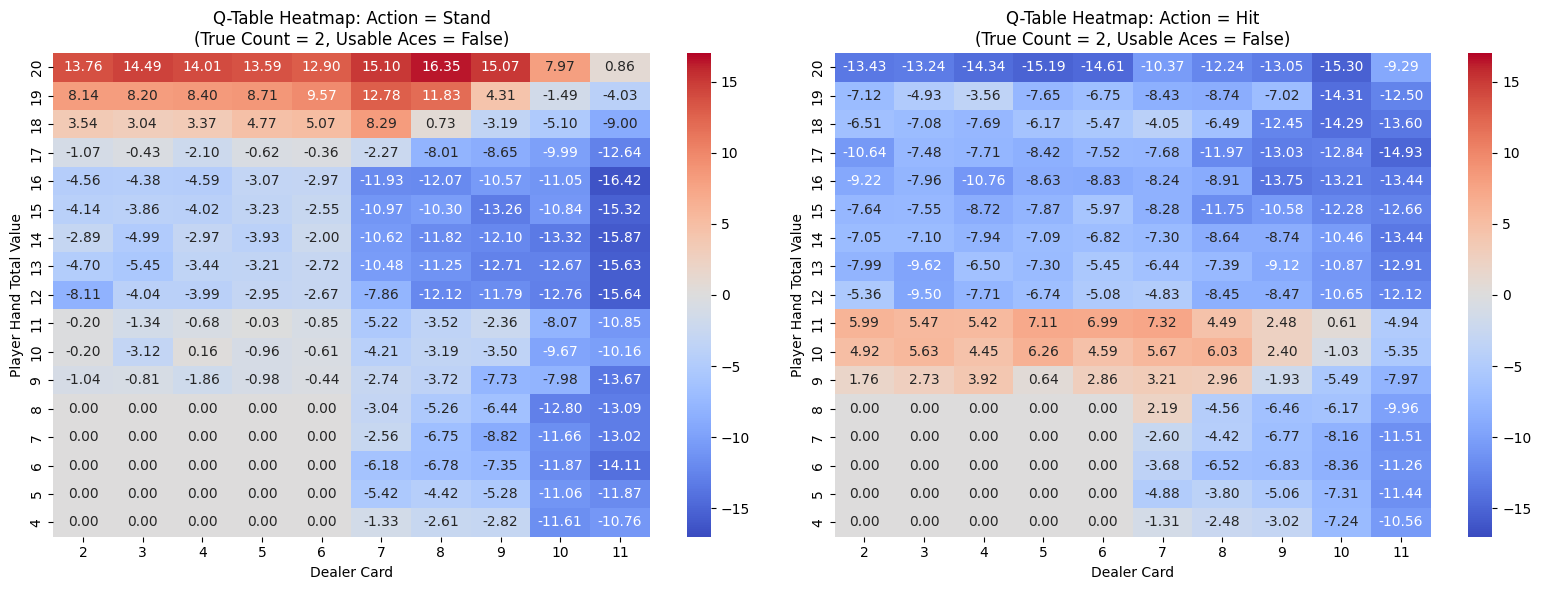

In [139]:
agent.plot_q_table(true_count=2, usable_aces=False)

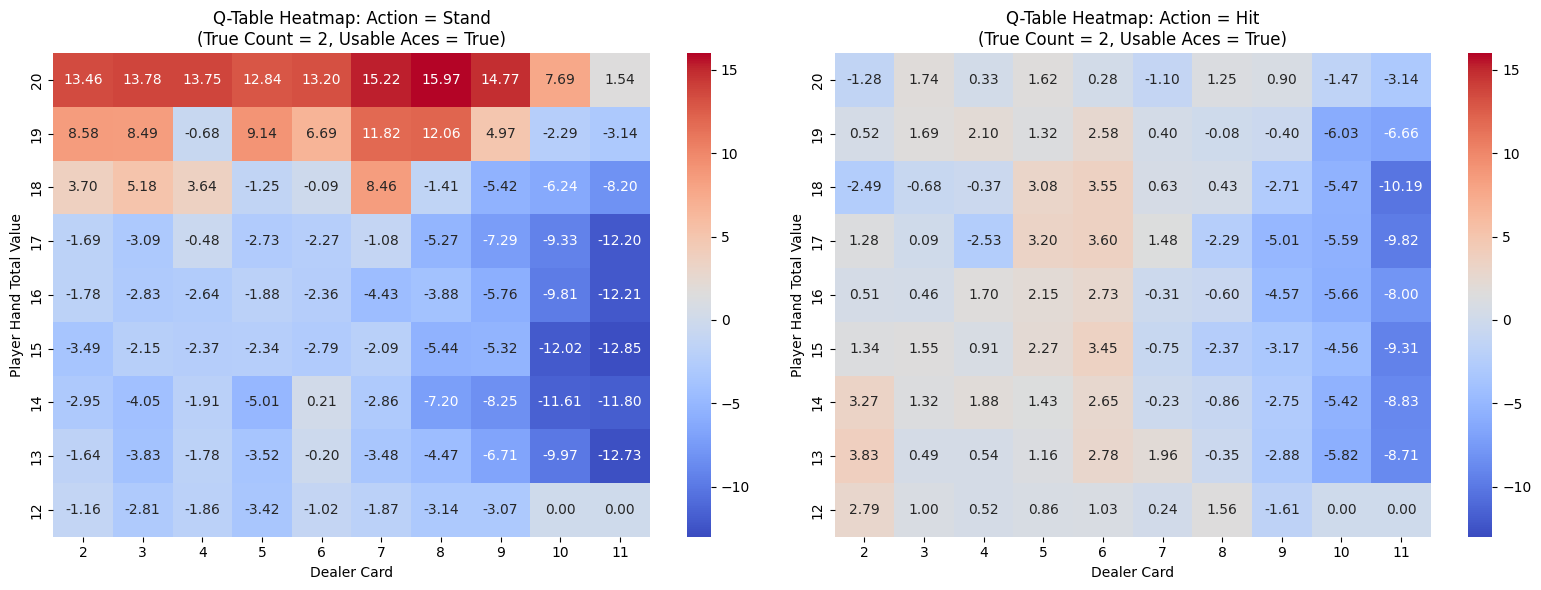

In [140]:
agent.plot_q_table(true_count=2, usable_aces=True)

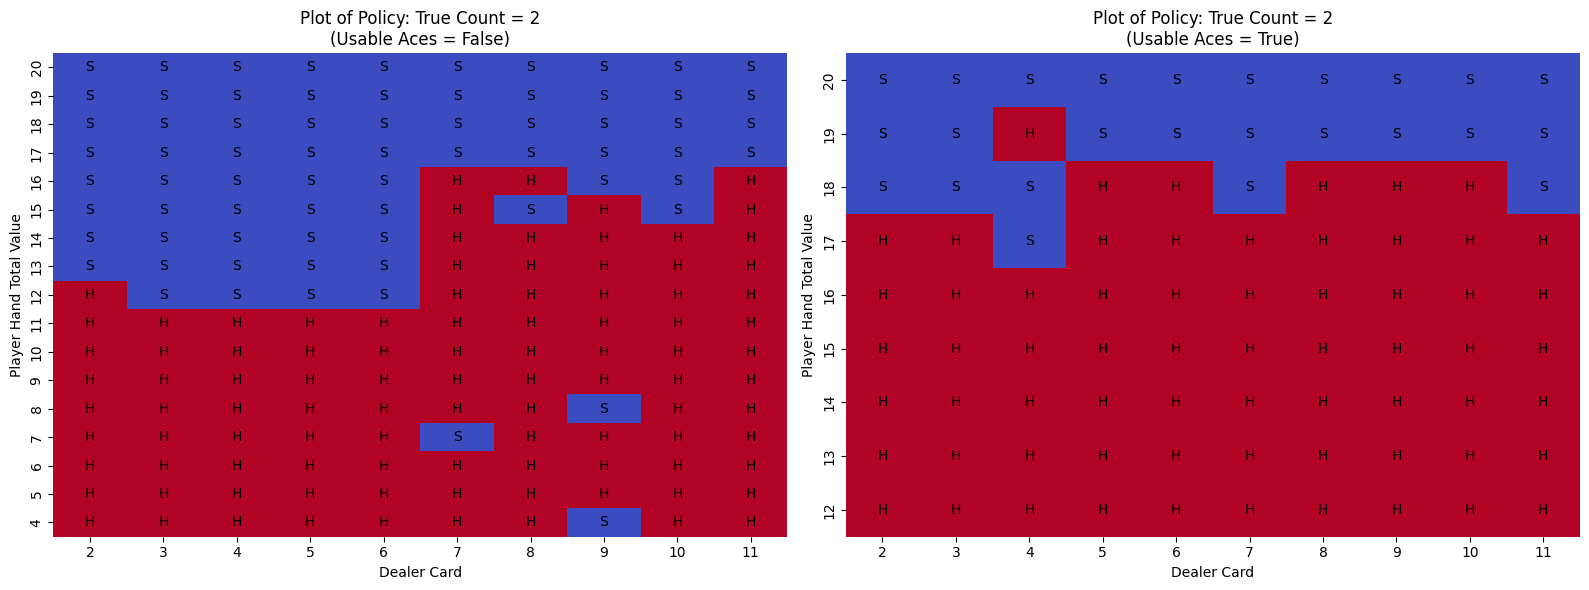

In [141]:
agent.plot_policy(true_count=2)

In [170]:
num_test_games = 10000
wins = 0
losses = 0
ties = 0
blackjack_count = 0
total_reward = 0
env = BlackjackGame()

for _ in tqdm(range(num_test_games), desc="Testing Games"):
    env.reset(true_count=2)
    game_reward, state, winner = env.new_game()  # Start a new game

    while not winner:
        # Get the best action based on the trained model
        action = agent.get_best_action(state)
        
        # Take the action in the environment
        reward, next_state, winner = env.step(action)
        
        # Accumulate reward for the current game
        game_reward += reward
        
        # Update the state
        state = next_state

    # Track total reward
    total_reward += game_reward

    # Step 3: Record the outcome
    if winner == 'player':
        wins += 1
    elif winner == 'blackjack':
        wins += 1
        blackjack_count += 1
    elif winner == 'dealer':
        losses += 1
    else:  # Tie
        ties += 1

# Compute performance metrics
win_rate = wins / num_test_games
loss_rate = losses / num_test_games
tie_rate = ties / num_test_games
average_reward = total_reward / num_test_games
blackjack_rate = blackjack_count / num_test_games

# Print results
print(f"Results after {num_test_games} test games:")
print(f"Win Rate: {win_rate:.2%}")
print(f"Loss Rate: {loss_rate:.2%}")
print(f"Tie Rate: {tie_rate:.2%}")
print(f"Blackjack Rate: {blackjack_rate:.2%}")
print(f"Total Reward: {total_reward}")
print(f"Average Reward: {average_reward:.2f}")

Testing Games: 100%|██████████| 10000/10000 [00:00<00:00, 14360.49it/s]

Results after 10000 test games:
Win Rate: 44.73%
Loss Rate: 47.54%
Tie Rate: 7.73%
Blackjack Rate: 6.48%
Total Reward: 860.0
Average Reward: 0.09


In [21]:
save_td_model(agent.Q, "models/q_learning.npy")

TD model is saved to models/q_learning.npy.


In [9]:
# Hyperparameter grids to search
hyperparameters = {
    "alpha_values": [0.1, 0.05],
    "gamma_values": [0.9, 0.95, 0.99],
    "epsilon_values": [0.2, 0.1, 0.05],
    "lambd_values": [0, 0.5, 0.7, 0.9, 1.0]
}

# Number of episodes for training and testing
num_train_episodes = 1000000
num_test_games = 1000000

# Fine-tuning loop
results = []

# Create environment
env = BlackjackGame()

# Placeholder for the best agent's Q-table
best_q_table = None

# Iterate over all combinations of hyperparameters
for alpha, gamma, epsilon, lambd in itertools.product(
    hyperparameters["alpha_values"],
    hyperparameters["gamma_values"],
    hyperparameters["epsilon_values"],
    hyperparameters["lambd_values"]
):
    print(f"\nTraining with alpha={alpha}, gamma={gamma}, epsilon={epsilon}, lambd={lambd}")

    # Create a new agent with the current hyperparameters
    agent = TemporalDifference(
        env=env,
        alpha=alpha,    # Learning rate
        gamma=gamma,    # Discount factor
        epsilon=epsilon,  # Exploration rate
        lambd=lambd     # Trace decay
    )

    # Train the agent
    agent.train(num_episodes=num_train_episodes, on_policy=False, true_count=2)

    # Test the agent
    test_results = test_td_model(agent, env, num_test_games=num_test_games)

    # Print the test results
    print(f"Test Results for alpha={alpha}, gamma={gamma}, epsilon={epsilon}, lambd={lambd}:")
    for key, value in test_results.items():
        if key.endswith("rate"):
            print(f"{key.capitalize().replace('_', ' ')}: {value:.2%}")
        else:
            print(f"{key.capitalize().replace('_', ' ')}: {value}")

    # Save results
    results.append({
        "alpha": alpha,
        "gamma": gamma,
        "epsilon": epsilon,
        "lambd": lambd,
        **test_results
    })

    # Update the best Q-table if this agent has the highest win rate
    if best_q_table is None or test_results["win_rate"] > max(r["win_rate"] for r in results[:-1]):
        best_q_table = agent.Q

# Find the best hyperparameter combination based on win rate
best_result = max(results, key=lambda x: x["win_rate"])

print("\nBest Hyperparameter Combination:")
print(f"Alpha: {best_result['alpha']}")
print(f"Gamma: {best_result['gamma']}")
print(f"Epsilon: {best_result['epsilon']}")
print(f"Lambd: {best_result['lambd']}")
print(f"Win Rate: {best_result['win_rate']:.2%}")
print(f"Average Reward: {best_result['average_reward']:.2f}")

# Save the best model
save_td_model(best_q_table, "models/best_q_learning.npy")


Training with alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14763.44it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0:
Win rate: 43.10%
Loss rate: 48.27%
Tie rate: 8.63%
Blackjack rate: 5.95%
Total reward: -439060.0
Average reward: -0.43906

Training with alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14805.74it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0.5:
Win rate: 43.43%
Loss rate: 48.27%
Tie rate: 8.29%
Blackjack rate: 5.94%
Total reward: -374250.0
Average reward: -0.37425

Training with alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14805.99it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0.7:
Win rate: 43.44%
Loss rate: 48.26%
Tie rate: 8.30%
Blackjack rate: 5.93%
Total reward: -372290.0
Average reward: -0.37229

Training with alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14852.15it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.2, lambd=0.9:
Win rate: 43.26%
Loss rate: 48.19%
Tie rate: 8.55%
Blackjack rate: 5.94%
Total reward: -391020.0
Average reward: -0.39102

Training with alpha=0.1, gamma=0.9, epsilon=0.2, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14871.37it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.2, lambd=1.0:
Win rate: 43.77%
Loss rate: 48.48%
Tie rate: 7.75%
Blackjack rate: 5.95%
Total reward: -347940.0
Average reward: -0.34794

Training with alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14789.09it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0:
Win rate: 43.00%
Loss rate: 48.40%
Tie rate: 8.60%
Blackjack rate: 5.91%
Total reward: -487600.0
Average reward: -0.4876

Training with alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14771.58it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.5:
Win rate: 43.19%
Loss rate: 48.26%
Tie rate: 8.56%
Blackjack rate: 5.93%
Total reward: -420430.0
Average reward: -0.42043

Training with alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14783.98it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.7:
Win rate: 43.37%
Loss rate: 48.26%
Tie rate: 8.38%
Blackjack rate: 5.95%
Total reward: -383050.0
Average reward: -0.38305

Training with alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14755.16it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.9:
Win rate: 43.33%
Loss rate: 48.39%
Tie rate: 8.29%
Blackjack rate: 5.94%
Total reward: -418410.0
Average reward: -0.41841

Training with alpha=0.1, gamma=0.9, epsilon=0.1, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14834.46it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.1, lambd=1.0:
Win rate: 43.71%
Loss rate: 48.37%
Tie rate: 7.92%
Blackjack rate: 5.95%
Total reward: -336220.0
Average reward: -0.33622

Training with alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14747.52it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0:
Win rate: 42.83%
Loss rate: 48.50%
Tie rate: 8.67%
Blackjack rate: 5.93%
Total reward: -541560.0
Average reward: -0.54156

Training with alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14804.93it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0.5:
Win rate: 43.33%
Loss rate: 48.35%
Tie rate: 8.32%
Blackjack rate: 5.95%
Total reward: -410440.0
Average reward: -0.41044

Training with alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14812.46it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0.7:
Win rate: 43.39%
Loss rate: 48.54%
Tie rate: 8.07%
Blackjack rate: 5.96%
Total reward: -434110.0
Average reward: -0.43411

Training with alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14783.02it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.05, lambd=0.9:
Win rate: 43.43%
Loss rate: 48.23%
Tie rate: 8.34%
Blackjack rate: 5.94%
Total reward: -364680.0
Average reward: -0.36468

Training with alpha=0.1, gamma=0.9, epsilon=0.05, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14826.13it/s]


Test Results for alpha=0.1, gamma=0.9, epsilon=0.05, lambd=1.0:
Win rate: 43.52%
Loss rate: 48.57%
Tie rate: 7.92%
Blackjack rate: 5.97%
Total reward: -412730.0
Average reward: -0.41273

Training with alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14780.55it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0:
Win rate: 43.33%
Loss rate: 48.05%
Tie rate: 8.62%
Blackjack rate: 5.95%
Total reward: -347870.0
Average reward: -0.34787

Training with alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14801.16it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0.5:
Win rate: 43.49%
Loss rate: 48.35%
Tie rate: 8.16%
Blackjack rate: 5.96%
Total reward: -375320.0
Average reward: -0.37532

Training with alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14761.37it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0.7:
Win rate: 43.23%
Loss rate: 48.37%
Tie rate: 8.40%
Blackjack rate: 5.95%
Total reward: -432870.0
Average reward: -0.43287

Training with alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14891.23it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.2, lambd=0.9:
Win rate: 43.56%
Loss rate: 48.40%
Tie rate: 8.03%
Blackjack rate: 5.93%
Total reward: -374900.0
Average reward: -0.3749

Training with alpha=0.1, gamma=0.95, epsilon=0.2, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14854.34it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.2, lambd=1.0:
Win rate: 43.41%
Loss rate: 48.29%
Tie rate: 8.30%
Blackjack rate: 5.95%
Total reward: -379570.0
Average reward: -0.37957

Training with alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14805.38it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0:
Win rate: 43.26%
Loss rate: 48.54%
Tie rate: 8.21%
Blackjack rate: 5.97%
Total reward: -459330.0
Average reward: -0.45933

Training with alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14825.57it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0.5:
Win rate: 43.37%
Loss rate: 48.30%
Tie rate: 8.33%
Blackjack rate: 5.95%
Total reward: -392410.0
Average reward: -0.39241

Training with alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14749.26it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0.7:
Win rate: 43.38%
Loss rate: 48.38%
Tie rate: 8.24%
Blackjack rate: 5.97%
Total reward: -401870.0
Average reward: -0.40187

Training with alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14712.92it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.1, lambd=0.9:
Win rate: 43.25%
Loss rate: 48.42%
Tie rate: 8.32%
Blackjack rate: 5.94%
Total reward: -439590.0
Average reward: -0.43959

Training with alpha=0.1, gamma=0.95, epsilon=0.1, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14817.62it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.1, lambd=1.0:
Win rate: 43.52%
Loss rate: 48.49%
Tie rate: 7.99%
Blackjack rate: 5.89%
Total reward: -404260.0
Average reward: -0.40426

Training with alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14778.63it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0:
Win rate: 43.08%
Loss rate: 48.25%
Tie rate: 8.67%
Blackjack rate: 5.99%
Total reward: -435140.0
Average reward: -0.43514

Training with alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14782.21it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0.5:
Win rate: 42.87%
Loss rate: 48.45%
Tie rate: 8.69%
Blackjack rate: 5.91%
Total reward: -525120.0
Average reward: -0.52512

Training with alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14788.02it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0.7:
Win rate: 43.32%
Loss rate: 48.31%
Tie rate: 8.36%
Blackjack rate: 5.93%
Total reward: -405610.0
Average reward: -0.40561

Training with alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14830.84it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.05, lambd=0.9:
Win rate: 43.30%
Loss rate: 48.26%
Tie rate: 8.45%
Blackjack rate: 5.94%
Total reward: -398090.0
Average reward: -0.39809

Training with alpha=0.1, gamma=0.95, epsilon=0.05, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14843.53it/s]


Test Results for alpha=0.1, gamma=0.95, epsilon=0.05, lambd=1.0:
Win rate: 43.42%
Loss rate: 48.15%
Tie rate: 8.43%
Blackjack rate: 5.98%
Total reward: -349020.0
Average reward: -0.34902

Training with alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14855.14it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0:
Win rate: 43.47%
Loss rate: 48.22%
Tie rate: 8.31%
Blackjack rate: 5.96%
Total reward: -353710.0
Average reward: -0.35371

Training with alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14885.40it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0.5:
Win rate: 43.53%
Loss rate: 48.62%
Tie rate: 7.85%
Blackjack rate: 5.95%
Total reward: -422930.0
Average reward: -0.42293

Training with alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14786.33it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0.7:
Win rate: 43.35%
Loss rate: 48.19%
Tie rate: 8.46%
Blackjack rate: 5.93%
Total reward: -375700.0
Average reward: -0.3757

Training with alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14826.87it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.2, lambd=0.9:
Win rate: 43.49%
Loss rate: 48.51%
Tie rate: 8.00%
Blackjack rate: 5.91%
Total reward: -412330.0
Average reward: -0.41233

Training with alpha=0.1, gamma=0.99, epsilon=0.2, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14818.55it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.2, lambd=1.0:
Win rate: 43.48%
Loss rate: 48.32%
Tie rate: 8.21%
Blackjack rate: 5.94%
Total reward: -374260.0
Average reward: -0.37426

Training with alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14737.28it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0:
Win rate: 43.25%
Loss rate: 48.32%
Tie rate: 8.43%
Blackjack rate: 5.95%
Total reward: -420800.0
Average reward: -0.4208

Training with alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14771.43it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.5:
Win rate: 43.15%
Loss rate: 48.24%
Tie rate: 8.61%
Blackjack rate: 5.95%
Total reward: -423170.0
Average reward: -0.42317

Training with alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14788.57it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.7:
Win rate: 43.34%
Loss rate: 48.34%
Tie rate: 8.32%
Blackjack rate: 5.96%
Total reward: -406060.0
Average reward: -0.40606

Training with alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14865.43it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.9:
Win rate: 43.60%
Loss rate: 48.56%
Tie rate: 7.84%
Blackjack rate: 5.91%
Total reward: -399680.0
Average reward: -0.39968

Training with alpha=0.1, gamma=0.99, epsilon=0.1, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14823.54it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.1, lambd=1.0:
Win rate: 43.30%
Loss rate: 48.37%
Tie rate: 8.32%
Blackjack rate: 5.94%
Total reward: -419550.0
Average reward: -0.41955

Training with alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14749.42it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0:
Win rate: 43.26%
Loss rate: 48.41%
Tie rate: 8.33%
Blackjack rate: 5.98%
Total reward: -433860.0
Average reward: -0.43386

Training with alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14780.61it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0.5:
Win rate: 43.23%
Loss rate: 48.34%
Tie rate: 8.43%
Blackjack rate: 5.92%
Total reward: -428710.0
Average reward: -0.42871

Training with alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14783.11it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0.7:
Win rate: 43.33%
Loss rate: 48.51%
Tie rate: 8.16%
Blackjack rate: 5.93%
Total reward: -442650.0
Average reward: -0.44265

Training with alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14828.82it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.05, lambd=0.9:
Win rate: 43.50%
Loss rate: 48.57%
Tie rate: 7.93%
Blackjack rate: 5.92%
Total reward: -422650.0
Average reward: -0.42265

Training with alpha=0.1, gamma=0.99, epsilon=0.05, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14834.56it/s]


Test Results for alpha=0.1, gamma=0.99, epsilon=0.05, lambd=1.0:
Win rate: 43.36%
Loss rate: 48.26%
Tie rate: 8.38%
Blackjack rate: 5.92%
Total reward: -386230.0
Average reward: -0.38623

Training with alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:08<00:00, 14702.01it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0:
Win rate: 43.19%
Loss rate: 48.18%
Tie rate: 8.63%
Blackjack rate: 5.92%
Total reward: -405110.0
Average reward: -0.40511

Training with alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14790.40it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0.5:
Win rate: 43.50%
Loss rate: 48.16%
Tie rate: 8.34%
Blackjack rate: 5.93%
Total reward: -339070.0
Average reward: -0.33907

Training with alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14784.11it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0.7:
Win rate: 43.52%
Loss rate: 48.26%
Tie rate: 8.22%
Blackjack rate: 5.93%
Total reward: -355470.0
Average reward: -0.35547

Training with alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14769.36it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.2, lambd=0.9:
Win rate: 43.51%
Loss rate: 48.09%
Tie rate: 8.40%
Blackjack rate: 5.93%
Total reward: -321600.0
Average reward: -0.3216

Training with alpha=0.05, gamma=0.9, epsilon=0.2, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14793.72it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.2, lambd=1.0:
Win rate: 43.74%
Loss rate: 48.21%
Tie rate: 8.05%
Blackjack rate: 5.96%
Total reward: -299060.0
Average reward: -0.29906

Training with alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14791.95it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0:
Win rate: 43.23%
Loss rate: 48.19%
Tie rate: 8.58%
Blackjack rate: 5.93%
Total reward: -398690.0
Average reward: -0.39869

Training with alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14733.09it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0.5:
Win rate: 43.17%
Loss rate: 48.21%
Tie rate: 8.62%
Blackjack rate: 5.95%
Total reward: -412570.0
Average reward: -0.41257

Training with alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14749.06it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0.7:
Win rate: 43.46%
Loss rate: 48.23%
Tie rate: 8.31%
Blackjack rate: 5.96%
Total reward: -358250.0
Average reward: -0.35825

Training with alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14847.18it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.1, lambd=0.9:
Win rate: 43.56%
Loss rate: 48.34%
Tie rate: 8.11%
Blackjack rate: 5.95%
Total reward: -360460.0
Average reward: -0.36046

Training with alpha=0.05, gamma=0.9, epsilon=0.1, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14801.17it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.1, lambd=1.0:
Win rate: 43.47%
Loss rate: 48.11%
Tie rate: 8.42%
Blackjack rate: 5.98%
Total reward: -331600.0
Average reward: -0.3316

Training with alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14742.43it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0:
Win rate: 43.24%
Loss rate: 48.23%
Tie rate: 8.54%
Blackjack rate: 5.94%
Total reward: -405090.0
Average reward: -0.40509

Training with alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14779.26it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0.5:
Win rate: 43.29%
Loss rate: 48.17%
Tie rate: 8.55%
Blackjack rate: 5.95%
Total reward: -380870.0
Average reward: -0.38087

Training with alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14751.65it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0.7:
Win rate: 43.10%
Loss rate: 48.18%
Tie rate: 8.72%
Blackjack rate: 5.92%
Total reward: -424270.0
Average reward: -0.42427

Training with alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14875.82it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.05, lambd=0.9:
Win rate: 43.51%
Loss rate: 48.23%
Tie rate: 8.26%
Blackjack rate: 5.96%
Total reward: -348570.0
Average reward: -0.34857

Training with alpha=0.05, gamma=0.9, epsilon=0.05, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14817.63it/s]


Test Results for alpha=0.05, gamma=0.9, epsilon=0.05, lambd=1.0:
Win rate: 43.58%
Loss rate: 48.20%
Tie rate: 8.21%
Blackjack rate: 5.95%
Total reward: -329170.0
Average reward: -0.32917

Training with alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14802.29it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0:
Win rate: 43.47%
Loss rate: 48.17%
Tie rate: 8.35%
Blackjack rate: 5.95%
Total reward: -344860.0
Average reward: -0.34486

Training with alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14793.72it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0.5:
Win rate: 43.33%
Loss rate: 48.09%
Tie rate: 8.58%
Blackjack rate: 5.92%
Total reward: -359690.0
Average reward: -0.35969

Training with alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14827.31it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0.7:
Win rate: 43.73%
Loss rate: 48.39%
Tie rate: 7.88%
Blackjack rate: 5.94%
Total reward: -337490.0
Average reward: -0.33749

Training with alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14819.74it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.2, lambd=0.9:
Win rate: 43.62%
Loss rate: 48.39%
Tie rate: 8.00%
Blackjack rate: 5.96%
Total reward: -358860.0
Average reward: -0.35886

Training with alpha=0.05, gamma=0.95, epsilon=0.2, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14834.24it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.2, lambd=1.0:
Win rate: 43.67%
Loss rate: 48.53%
Tie rate: 7.80%
Blackjack rate: 5.91%
Total reward: -380110.0
Average reward: -0.38011

Training with alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14732.21it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0:
Win rate: 43.52%
Loss rate: 48.20%
Tie rate: 8.28%
Blackjack rate: 5.98%
Total reward: -336370.0
Average reward: -0.33637

Training with alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14717.02it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0.5:
Win rate: 43.38%
Loss rate: 48.19%
Tie rate: 8.43%
Blackjack rate: 5.95%
Total reward: -367490.0
Average reward: -0.36749

Training with alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14759.98it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0.7:
Win rate: 43.63%
Loss rate: 48.34%
Tie rate: 8.03%
Blackjack rate: 5.96%
Total reward: -344490.0
Average reward: -0.34449

Training with alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14765.31it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.1, lambd=0.9:
Win rate: 43.45%
Loss rate: 48.15%
Tie rate: 8.40%
Blackjack rate: 5.96%
Total reward: -344700.0
Average reward: -0.3447

Training with alpha=0.05, gamma=0.95, epsilon=0.1, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14784.16it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.1, lambd=1.0:
Win rate: 43.61%
Loss rate: 48.33%
Tie rate: 8.05%
Blackjack rate: 5.95%
Total reward: -348410.0
Average reward: -0.34841

Training with alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14788.49it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0:
Win rate: 43.10%
Loss rate: 48.30%
Tie rate: 8.60%
Blackjack rate: 5.95%
Total reward: -445380.0
Average reward: -0.44538

Training with alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14735.49it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0.5:
Win rate: 43.16%
Loss rate: 48.25%
Tie rate: 8.59%
Blackjack rate: 5.90%
Total reward: -428610.0
Average reward: -0.42861

Training with alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14754.79it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0.7:
Win rate: 43.53%
Loss rate: 48.39%
Tie rate: 8.07%
Blackjack rate: 5.94%
Total reward: -377810.0
Average reward: -0.37781

Training with alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:08<00:00, 14695.23it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.05, lambd=0.9:
Win rate: 43.45%
Loss rate: 48.12%
Tie rate: 8.43%
Blackjack rate: 5.95%
Total reward: -338670.0
Average reward: -0.33867

Training with alpha=0.05, gamma=0.95, epsilon=0.05, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14841.55it/s]


Test Results for alpha=0.05, gamma=0.95, epsilon=0.05, lambd=1.0:
Win rate: 43.72%
Loss rate: 48.44%
Tie rate: 7.84%
Blackjack rate: 5.99%
Total reward: -346910.0
Average reward: -0.34691

Training with alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14763.60it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0:
Win rate: 43.34%
Loss rate: 48.17%
Tie rate: 8.49%
Blackjack rate: 5.94%
Total reward: -371970.0
Average reward: -0.37197

Training with alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14750.11it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0.5:
Win rate: 43.37%
Loss rate: 48.31%
Tie rate: 8.32%
Blackjack rate: 5.95%
Total reward: -392540.0
Average reward: -0.39254

Training with alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14716.28it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0.7:
Win rate: 43.46%
Loss rate: 48.10%
Tie rate: 8.44%
Blackjack rate: 5.91%
Total reward: -337500.0
Average reward: -0.3375

Training with alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14770.85it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.2, lambd=0.9:
Win rate: 43.61%
Loss rate: 48.40%
Tie rate: 8.00%
Blackjack rate: 5.94%
Total reward: -363680.0
Average reward: -0.36368

Training with alpha=0.05, gamma=0.99, epsilon=0.2, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14803.71it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.2, lambd=1.0:
Win rate: 43.62%
Loss rate: 48.43%
Tie rate: 7.95%
Blackjack rate: 5.92%
Total reward: -371130.0
Average reward: -0.37113

Training with alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14758.45it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0:
Win rate: 43.39%
Loss rate: 48.36%
Tie rate: 8.25%
Blackjack rate: 5.92%
Total reward: -402980.0
Average reward: -0.40298

Training with alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14737.82it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0.5:
Win rate: 43.20%
Loss rate: 48.17%
Tie rate: 8.63%
Blackjack rate: 5.95%
Total reward: -400190.0
Average reward: -0.40019

Training with alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14786.01it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0.7:
Win rate: 43.56%
Loss rate: 48.21%
Tie rate: 8.23%
Blackjack rate: 5.93%
Total reward: -336540.0
Average reward: -0.33654

Training with alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14827.95it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.1, lambd=0.9:
Win rate: 43.77%
Loss rate: 48.18%
Tie rate: 8.05%
Blackjack rate: 5.97%
Total reward: -285650.0
Average reward: -0.28565

Training with alpha=0.05, gamma=0.99, epsilon=0.1, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14821.57it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.1, lambd=1.0:
Win rate: 43.66%
Loss rate: 48.22%
Tie rate: 8.12%
Blackjack rate: 5.99%
Total reward: -313270.0
Average reward: -0.31327

Training with alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14724.37it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0:
Win rate: 43.26%
Loss rate: 48.44%
Tie rate: 8.30%
Blackjack rate: 5.94%
Total reward: -443180.0
Average reward: -0.44318

Training with alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0.5


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14807.50it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0.5:
Win rate: 43.49%
Loss rate: 48.27%
Tie rate: 8.24%
Blackjack rate: 5.96%
Total reward: -359400.0
Average reward: -0.3594

Training with alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0.7


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14777.17it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0.7:
Win rate: 43.55%
Loss rate: 48.24%
Tie rate: 8.22%
Blackjack rate: 5.93%
Total reward: -345050.0
Average reward: -0.34505

Training with alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0.9


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14809.70it/s]


Test Results for alpha=0.05, gamma=0.99, epsilon=0.05, lambd=0.9:
Win rate: 43.69%
Loss rate: 48.61%
Tie rate: 7.69%
Blackjack rate: 5.95%
Total reward: -388090.0
Average reward: -0.38809

Training with alpha=0.05, gamma=0.99, epsilon=0.05, lambd=1.0


Testing Games: 100%|██████████| 1000000/1000000 [01:07<00:00, 14853.33it/s]

Test Results for alpha=0.05, gamma=0.99, epsilon=0.05, lambd=1.0:
Win rate: 43.91%
Loss rate: 48.53%
Tie rate: 7.56%
Blackjack rate: 5.97%
Total reward: -327300.0
Average reward: -0.3273

Best Hyperparameter Combination:
Alpha: 0.05
Gamma: 0.99
Epsilon: 0.05
Lambd: 1.0
Win Rate: 43.91%
Average Reward: -0.33
TD model is saved to models/best_q_learning.npy.
